# **BERTopic sur des transcription du podcast**

BERTopic est un puissant framework pour analyser les données textuelles.
Nous allons l'utiliser dans ce projet pour analyser des transcriptions du podcast [GDIY](https://www.gdiy.fr/).
Les données ont été netoyées pour faciliter la compréhension. Vous pouvez trouver les données sur ce repo [Github](https://github.com/MNIKIEMA/gdiy-search/tree/main/gdiy_json_data).

**Disclaimer**: Je ne suis pas sponsorisé par le podcast Génération Do It Yourself.

In [1]:
%%capture

#!pip install safetensors
#%pip install datasets
#%pip install datashader
#%pip install adjustText

# **La base de donnée**
- Les transcriptions ont été nettoyées en supprimant les mots non important
- Les données sont de format `json` et subdivisées en petit bloc pour calculer les embeddings
- On a le format suivant:
```json
{
    "text": ["text_1", "text_2", "etc"],
    "date": ["date_1", "date_2", "etc"]
}
```

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import json
from tqdm.auto import tqdm
import os
from nltk.corpus import stopwords
import numpy as np

In [2]:
stopword = stopwords.words('french')
stopword += ['ouais', 'épisode', 'faire', 'morgan','prudhomme', 'lire', 'génération','podcast', 'gdiy',
           'recommande','deux','quand','the','livre', 'être','yourself', 'orso', 'doi', 'an',
           'merci', 'avoir','timeline','face','million','monde', 'vie','and','fait','abonnez', 'parce',
             'ouai', 'sai', 'it', 'do', 'mets', 'yourself','si', 'chose','oui', 'truc', 'dessus', 'traite',
             'that', 'fai', 'accord', 'gens', 'exemple', 'cosa', 'legalstart', 'start']

In [3]:
import json
with open('./dataset/clean_docs.json', 'r') as f:
    data = json.load(f)

docs = data['text']
date = data['date']

print(len(docs))

49892


# **Premier pas avec Bertopic**

- On va illustrer l'entrainement sur une base de donnée en utiliser quelques lignes de codes.
- Plus tard, nous allons explorer la modularité de `Bertopic`

## Embeddings

- Nous pré-calculerons et sauvegarderons les embeddings pour le modèle BERTopic
- Cela nous permet de gagner du temps en évitant cette étape lors des itérations futures sur le modèle.

In [11]:
# Creation des embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') #'sentence-transformers/all-MiniLM-L6-v2'
embeddings = model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/1560 [00:00<?, ?it/s]

Il est recommendé de sauvegarder les embeddings pour ne pas les calculer tout temps:

In [12]:
with open('./embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

- On peut les charger en mémoire comme suit:

In [4]:
embeddings = np.load('./embeddings.npy')

In [5]:
embeddings.shape

(49892, 384)

## Preparation du vocabulaire

L'auteur suggère de préparer le vocabulaire en amont pour économiser de la mémoire avant d'entraîner leur modèle.

Cette étape, bien que facultative avec assez de RAM, peut aider à réduire son utilisation. 

Il recommande aussi d'utiliser un `CountVectorizer` personnalisé plutôt que le `CountVectorizer` par défaut, s'il est disponible.

In [6]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Construction du vocabulaire
vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
  vocab.update(tokenizer(doc))

# On garde les mots dont la fréquence est supérieur à 15
vocab = [word for word, frequency in vocab.items() if frequency >= 15]

100%|██████████| 49892/49892 [00:00<00:00, 104374.97it/s]


- On peut ainsi voir le nombre de mots dans notre vocabulaire

In [7]:
len(vocab)

6731

## Entrainement de `BERTopic`

Nous pouvons entraîner notre modèle `BERTopic`.

Nous sélectionnons un modèle d'embeddings de phrases de la librairie SentenceTransformer et nous choisissons les modèles `HDBSCAN` et `UMAP`. 

Nvidia a développé des versions accélérées par GPU de `HDBSCAN` et `UMAP`, ce qui permet d'améliorer l'entraînement sur un ensemble de données aussi volumineux.

In [8]:
from umap import UMAP
import hdbscan
from bertopic import BERTopic

# Preparation des modèles

#
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# UMAP
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42,
                  metric="cosine", verbose=True)
# HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_samples=20, gen_min_span_tree=True,
                                prediction_data=False, min_cluster_size=20)
# Vectorizer
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True
).fit(docs, embeddings=embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_neighbors=50, random_state=42, verbose=True)
Sat Nov 18 20:55:44 2023 Construct fuzzy simplicial set
Sat Nov 18 20:55:44 2023 Finding Nearest Neighbors
Sat Nov 18 20:55:44 2023 Building RP forest with 16 trees
Sat Nov 18 20:55:48 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Sat Nov 18 20:56:04 2023 Finished Nearest Neighbor Search
Sat Nov 18 20:56:07 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

2023-11-18 20:56:55,419 - BERTopic - Reduced dimensionality


Sat Nov 18 20:56:55 2023 Finished embedding


2023-11-18 20:56:57,965 - BERTopic - Clustered reduced embeddings
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\bertopic\vectorizers\_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


Nous pouvons examiner les sujets comme suit :

In [9]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,31771,-1_coup_boîte_temps_moment,"[coup, boîte, temps, moment, fois, personne, j...",[ensemble trois coup idée france france péruvi...
1,0,992,0_restaurant_chef_cuisine_café,"[restaurant, chef, cuisine, café, restauration...",[restaurant quartier fooding restaurant quarti...
2,1,811,1_musique_album_artiste_disque,"[musique, album, artiste, disque, dj, piano, c...",[rencontre coup titre tube cas europe sud vrai...
3,2,689,2_entrepreneur_entrepreneuriat_investisseur_pr...,"[entrepreneur, entrepreneuriat, investisseur, ...",[plein façon entrepreneur entrepreneur entrepr...
4,3,520,3_moment_armée_chance_ontario,"[moment, armée, chance, ontario, projet, quest...",[place moment marché moment échange propos cha...
...,...,...,...,...,...
152,151,22,151_intelligence_cerveau_excellence_avenir,"[intelligence, cerveau, excellence, avenir, st...",[intelligence bullshit intelligence aig intell...
153,152,21,152_tiktok_follower_insta_youtube,"[tiktok, follower, insta, youtube, algorithme,...",[contenu viral cas follower règle 2023 mec ris...
154,153,21,153_planet_time_for_climatisation,"[planet, time, for, climatisation, planète, ai...",[time for planet dimension retour investisseme...
155,154,21,154_science_po_fac_connaissance,"[science, po, fac, connaissance, géant, dr, on...",[récit valeur coup science po puisque fonction...


In [34]:
topic_model.visualize_barchart()

## Visualiser la hiérarchie des thèmes

- Certaines thématiques sont en fait des sous-thèmes d'autres thématiques.
- Comprendre la hiérarchie permet de déterminer quelles thématiques devraient être fusionnées et lesquelles ne le devraient pas.

In [32]:
from scipy.cluster import hierarchy as sch
linkage_function = lambda x: sch.linkage(x, 'centroid', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)

100%|██████████| 136/136 [00:09<00:00, 14.34it/s]


In [33]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [10]:
from datetime import datetime
date_format = [datetime.strptime(date_time, "%d/%m/%Y") for date_time in date]

In [46]:
topics_over_time = topic_model.topics_over_time(docs, date_format,
                                                global_tuning=True,
                                                evolution_tuning=True,
                                                nr_bins=20)

topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

20it [02:42,  8.14s/it]


Enfin, on sauvegarder le modèle de la manière suivante :

In [50]:
topic_model.save(
    path='./BERTopic_Gdiy',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model='sentence-transformers/all-MiniLM-L6-v2'
)

# **Modularités**

- On peut tirer profit de la modularité pour entrainer chaque composant du modèle.
- Les modèles UMAP et HDBSCAN seront entrainés avant des les mettre dans `BERTopic`

## UMAP

- On peut jouer avec `n_components` qui donne la dimension du vecteur en sortie
- `n_neighbors` contrôle la façon dont l'algorithme équilibre la structure locale par rapport à la structure globale dans les données.
-  de faibles valeurs de `n_neighbors` se focalisent sur les détails locaux tandis que des valeurs élevées capturent les tendances globales des données, mais peuvent omettre certains détails.
- `metric` désigne la métrique utilisée : `cosine`, `euclidean`

In [14]:
from umap import UMAP

# On va appliquer une réduction de dimension avec une sortie de dimension 5
# et une distance cosinus
# On va également utiliser 15 voisins

umap_model = UMAP(n_components=5, n_neighbors=15, random_state=42, 
                  metric="cosine", verbose=True)
reduced_embeddings = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_components=5, random_state=42, verbose=True)
Sat Nov 18 21:15:38 2023 Construct fuzzy simplicial set
Sat Nov 18 21:15:38 2023 Finding Nearest Neighbors
Sat Nov 18 21:15:38 2023 Building RP forest with 16 trees
Sat Nov 18 21:15:38 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	Stopping threshold met -- exiting after 8 iterations
Sat Nov 18 21:15:40 2023 Finished Nearest Neighbor Search
Sat Nov 18 21:15:41 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sat Nov 18 21:16:15 2023 Finished embedding


Similarly, we can also prepare the UMAP-reduced embeddings for visualizing documents in 2D:

In [15]:
from umap import UMAP

# On applique ici une réduction de dimension avec une sortie de dimension 2
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42,
                  metric="cosine", verbose=True)

reduced_embeddings_2d = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', random_state=42, verbose=True)
Sat Nov 18 21:16:15 2023 Construct fuzzy simplicial set
Sat Nov 18 21:16:15 2023 Finding Nearest Neighbors
Sat Nov 18 21:16:15 2023 Building RP forest with 16 trees
Sat Nov 18 21:16:16 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	Stopping threshold met -- exiting after 8 iterations
Sat Nov 18 21:16:18 2023 Finished Nearest Neighbor Search
Sat Nov 18 21:16:18 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sat Nov 18 21:16:50 2023 Finished embedding


## HDBSCAN

Pour le clustering:
- `min_samples` désigne  le nombre minimum d'exemples requis dans un voisinage pour qu'un point soit considéré comme un noyau.
- `min_cluster_size` définit la taille minimale d'un cluster
- `gen_min_span_tree` générer l'arbre

In [16]:
from hdbscan import HDBSCAN

# Find clusters of semantically similar documents
hdbscan_model = HDBSCAN(min_samples=30, gen_min_span_tree=True,
                        prediction_data=False, min_cluster_size=30)
clusters = hdbscan_model.fit(reduced_embeddings).labels_

## Manual BERTopic

When we have pre-computed labels, we can pass them instead of having to calculate the clusters ourselves. This allows us to skip over the embedding, dimensionality, and clustering steps!

There is one more trick though that we are going to use. We could directly give BERTopic the reduced embeddings but BERTopic will use those to create topic vectors which is not ideal. Instead, we are giving the model the full embeddings and create a custom dimensionality reduction class that will return the reduced embeddings. This gives us the best of both worlds!

In [20]:
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from bertopic.cluster import BaseCluster
from bertopic.representation import KeyBERTInspired


class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings


# Prepare sub-models
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
umap_model = Dimensionality(reduced_embeddings)
hdbscan_model = BaseCluster()
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))
representation_model = KeyBERTInspired()

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        verbose=True
).fit(docs, embeddings=embeddings, y=clusters)

2023-11-18 21:22:24,030 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-11-18 21:22:24,031 - BERTopic - Reduced dimensionality
2023-11-18 21:22:24,039 - BERTopic - Clustered reduced embeddings
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\bertopic\vectorizers\_ctfidf.py:69: RuntimeWarning:

divide by zero encountered in divide



In [19]:
topic_model.visualize_barchart()

## Visualize Documents

In [42]:
import itertools
import pandas as pd

# Couleurs pour la visalisation
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                           '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                           '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                           '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
                           '#ffffff', '#000000'])

color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Transformer les embeddings en dataframe
df = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1],
                   "Topic": [str(t) for t in topic_model.topics_]})

df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Calculer les centroids des clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

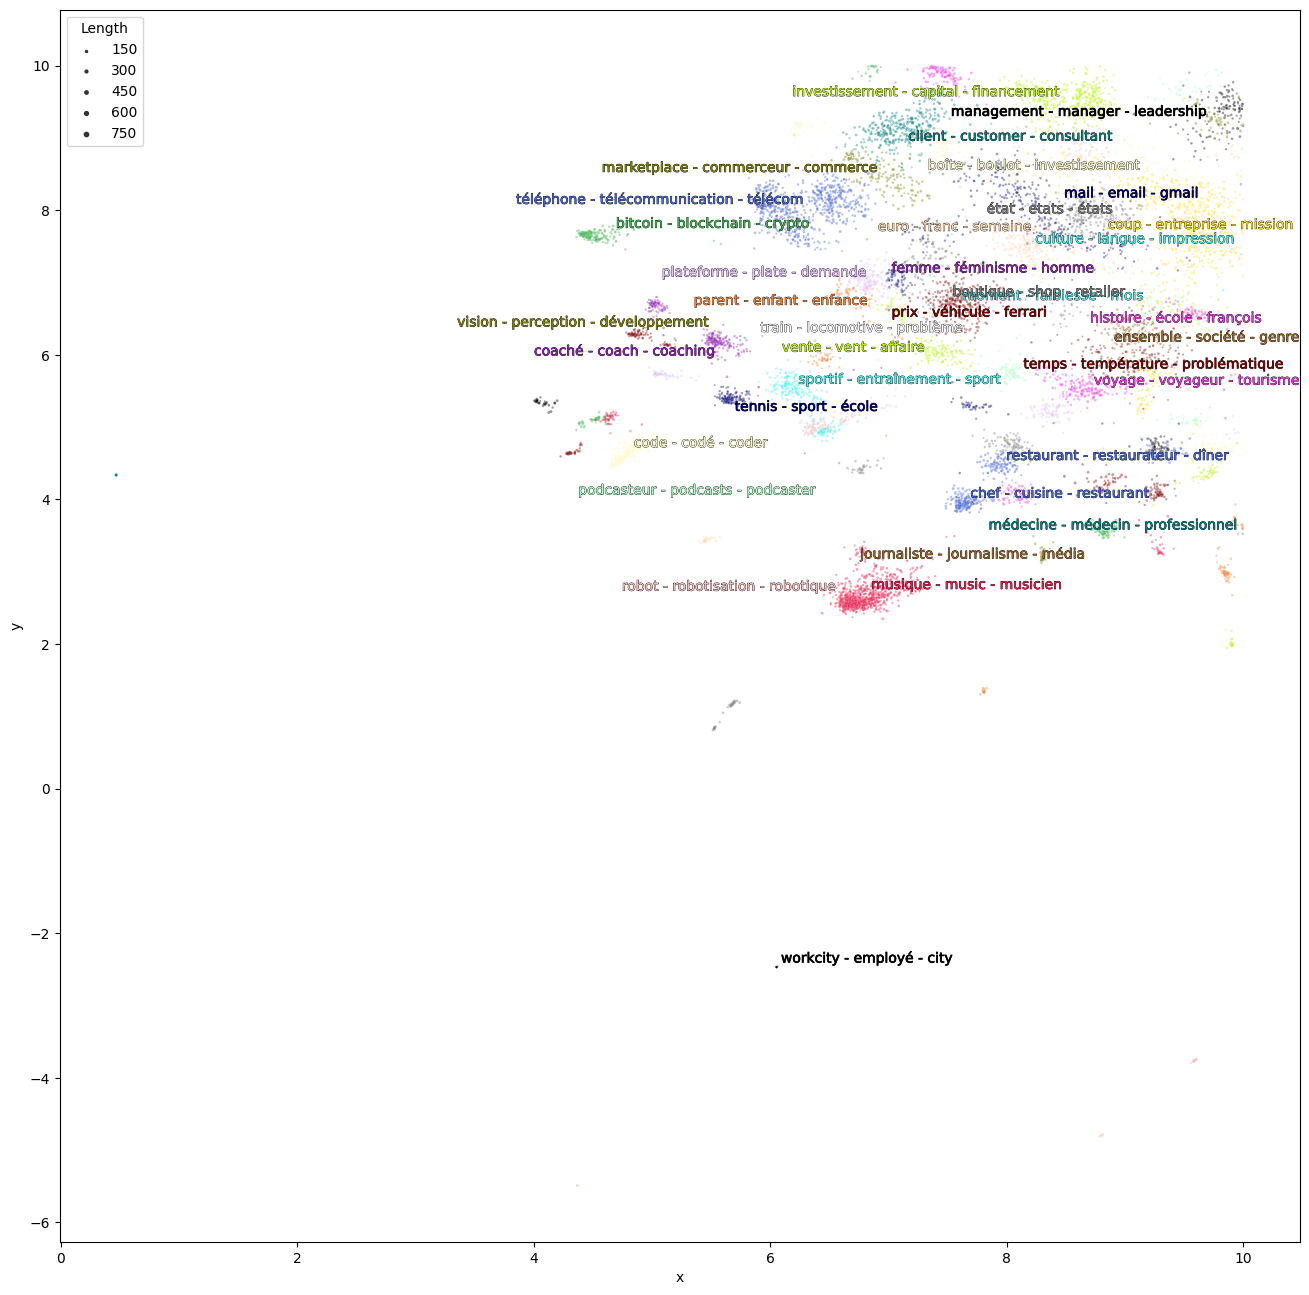

<Figure size 640x480 with 0 Axes>

In [47]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4,
                sizes=(0.4, 10), size="Length")

# Annotater les 50 premiers tthèmes
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center",
                          color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))


adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02),
            force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
plt.savefig("output.png", dpi=600)